In [1]:
!pip install MLForecast

In [2]:
!pip install optuna

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from mlforecast import MLForecast 
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from sklearn.metrics import mean_absolute_percentage_error
import warnings


warnings.filterwarnings('ignore')
sns.set()


general_data = pd.read_csv("./result.csv")
general_data.head(5255)

,Unnamed: 0,date,account_id,avg_xp_min,avg_gold_min,KDA,kills,assists,deaths,avg_KDA,...,sent,obs,rating_mu,rating_sigma,last_hits,avg_last_hits,denies,avg_denies,matches_amount,winrate
0,46,2015-11-06 10:00:30,40,816.000000,638.000000,9.666667,16,13,3,9.666667,...,0.000000,0.000000,26.880745,8.118755,5.154639,5.154639,0.360825,0.360825,1,1.000000
1,67,2015-11-06 22:56:38,64,592.000000,448.000000,2.555556,8,15,9,2.555556,...,0.000000,0.000000,26.880745,8.118755,2.981707,2.981707,0.073171,0.073171,1,1.000000
2,72,2015-11-06 23:43:14,72,403.000000,362.000000,0.481481,4,9,27,0.481481,...,0.465582,0.180225,26.880745,8.118755,2.012516,2.012516,0.015019,0.015019,1,1.000000
3,73,2015-11-06 23:43:14,71,414.000000,419.000000,1.615385,15,6,13,1.615385,...,0.015019,0.120150,26.880745,8.118755,3.499374,3.499374,0.000000,0.000000,1,1.000000
4,74,2015-11-06 23:43:14,68,368.000000,276.000000,4.111111,5,32,9,4.111111,...,0.060075,0.090113,23.119255,8.118755,2.177722,2.177722,0.015019,0.015019,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5250,37080,2015-11-12 23:36:30,21721,572.000000,486.250000,3.300000,10,23,10,3.602778,...,0.000000,0.000000,22.531634,7.594552,2.341857,4.529371,0.026918,0.206722,4,0.250000
5251,37091,2015-11-12 23:36:49,8101,512.750000,508.625000,3.888889,14,21,9,6.690467,...,0.000000,0.000000,26.870293,6.959072,3.381743,4.806090,0.041494,0.184786,8,0.625000
5252,37092,2015-11-12 23:36:49,16594,530.333333,488.666667,3.083333,15,22,12,5.472222,...,0.000000,0.000000,29.920950,7.744204,1.659751,3.689576,0.041494,0.099304,3,1.000000
5253,37094,2015-11-12 23:36:49,14238,387.714286,373.714286,4.800000,14,10,5,3.655495,...,0.000000,0.000000,32.510300,7.091068,7.385892,2.618113,0.228216,0.093802,7,0.857143


In [4]:
general_data["date"] = pd.to_datetime(general_data["date"])

In [5]:
general_data = general_data.sort_values(by=['matches_amount'])

In [6]:
general_data.head(500000)

,Unnamed: 0,date,account_id,avg_xp_min,avg_gold_min,KDA,kills,assists,deaths,avg_KDA,...,sent,obs,rating_mu,rating_sigma,last_hits,avg_last_hits,denies,avg_denies,matches_amount,winrate
0,46,2015-11-06 10:00:30,40,816.000000,638.000000,9.666667,16,13,3,9.666667,...,0.000000,0.000000,26.880745,8.118755,5.154639,5.154639,0.360825,0.360825,1,1.000000
2301,16576,2015-11-12 16:14:05,13608,611.000000,431.000000,1.818182,9,11,11,1.818182,...,0.000000,0.000000,22.861188,8.104918,1.913822,1.913822,0.100727,0.100727,1,0.000000
7379,50849,2015-11-13 07:19:46,37445,367.000000,383.000000,3.428571,6,18,7,3.428571,...,0.000000,0.000000,27.307216,8.096692,2.400865,2.400865,0.216294,0.216294,1,1.000000
28932,191017,2015-11-15 19:36:59,109932,359.000000,290.000000,1.250000,4,16,16,1.250000,...,0.046875,0.000000,22.949025,8.100936,2.273438,2.273438,0.070312,0.070312,1,0.000000
2307,16593,2015-11-12 16:14:12,13615,591.000000,527.000000,3.500000,13,15,8,3.500000,...,0.000000,0.000000,26.407122,8.140697,2.484922,2.484922,0.096502,0.096502,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45854,304458,2015-11-17 23:40:12,2701,381.522388,374.746269,0.909091,1,9,11,2.602850,...,0.108238,0.288635,23.558977,3.770400,2.236921,2.601018,0.000000,0.081643,67,0.462687
46079,305962,2015-11-18 00:15:15,2701,381.117647,374.470588,3.000000,4,26,10,2.608690,...,0.093787,0.187573,23.883693,3.748301,0.539273,2.570698,0.023447,0.080787,68,0.470588
47102,312848,2015-11-18 03:28:05,2701,383.231884,375.304348,1.750000,7,7,8,2.596246,...,0.000000,0.000000,23.676197,3.731152,6.268248,2.624286,0.082117,0.080806,69,0.463768
47351,314607,2015-11-18 04:16:16,2701,383.800000,377.971429,4.500000,9,18,6,2.623442,...,0.000000,0.058651,24.035382,3.707616,0.263930,2.590566,0.000000,0.079652,70,0.471429


In [7]:
filtered_features = ["account_id",
                      "avg_xp_min",
                      "avg_gold_min",
                      "avg_KDA",
                      "avg_kills",
                      "avg_assists",
                      "avg_deaths",
                      "avg_obs",
                      "avg_sent",
                      "rating_mu",
                      "rating_sigma",
                      "avg_last_hits",
                      "avg_denies",
                      #"winrate",
                      "matches_amount"]

In [8]:
filtered_data = general_data[filtered_features]

In [9]:
dynamic_features = ['avg_xp_min', 'avg_gold_min', 'avg_KDA', 'avg_kills', 'avg_assists', "avg_deaths", "avg_obs", "avg_sent",
                   #"rating_sigma", "avg_last_hits", "avg_denies", "winrate"]
                    "rating_sigma", "avg_last_hits", "avg_denies"]

In [10]:
def objective_XGB(trial):
    test_df = pd.DataFrame(columns=filtered_features)
    train_df = pd.DataFrame(columns=filtered_features)
    unique_ids_test = filtered_data.account_id.unique()
    for i in unique_ids_test:
        id_df = filtered_data[filtered_data["account_id"] == i]
        max_x = id_df.loc[id_df["matches_amount"].idxmax()]["matches_amount"] - 4
        train_df = pd.concat([train_df, id_df[id_df["matches_amount"] <= max_x]], ignore_index = True)
        test_df = pd.concat([test_df, id_df[id_df["matches_amount"] > max_x]], ignore_index = True)

    train_df = train_df.astype({'matches_amount':'int'})
    test_df = test_df.astype({'matches_amount':'int'})
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    models = [XGBRegressor(random_state=0, n_estimators=500,    learning_rate=learning_rate, max_depth=max_depth,
                           min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree)]

    model = MLForecast(models=models,
                   num_threads=10)

    model.fit(train_df, id_col='account_id', time_col='matches_amount', target_col='rating_mu',
              static_features=[], max_horizon=4)

    p = model.predict(horizon=4, dynamic_dfs=[test_df[['account_id','matches_amount'] + dynamic_features]])
    p = p.merge(test_df[['account_id', 'matches_amount', 'rating_mu']], on=['account_id', 'matches_amount'], how='left')

    error = mean_absolute_percentage_error(p['rating_mu'], p['XGBRegressor'])
    
    return error

In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_XGB, n_trials=10)

[I 2023-06-15 12:24:23,761] A new study created in memory with name: no-name-c33a93e7-f069-4dd3-a7a7-3d3e077ffb04
[I 2023-06-15 12:24:46,602] Trial 0 finished with value: 0.09887343203775936 and parameters: {'learning_rate': 0.0063885008537130925, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9702031753774021, 'colsample_bytree': 0.7779421246514351}. Best is trial 0 with value: 0.09887343203775936.
[I 2023-06-15 12:25:09,191] Trial 1 finished with value: 0.09022497823557661 and parameters: {'learning_rate': 0.010801627728504092, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.16097869789519675, 'colsample_bytree': 0.7942092157243963}. Best is trial 1 with value: 0.09022497823557661.
[I 2023-06-15 12:25:34,645] Trial 2 finished with value: 0.09102652070179336 and parameters: {'learning_rate': 0.012500850723923113, 'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.43724931515126897, 'colsample_bytree': 0.8482642134274652}. Best is trial 1 with value: 0.090224978235576

In [12]:
models = [make_pipeline(SimpleImputer(), 
                        RandomForestRegressor(random_state=0, n_estimators=500)),
          XGBRegressor(random_state=0, n_estimators=500, learning_rate=study.best_params["learning_rate"],
                        max_depth=study.best_params["max_depth"], min_child_weight=study.best_params["min_child_weight"],
                        subsample=study.best_params["subsample"], colsample_bytree=study.best_params["colsample_bytree"])]


model = MLForecast(models=models,
                   num_threads=10)

In [13]:
unique_ids = general_data.account_id.unique()
unique_ids.sort()

In [14]:
result_change_df = pd.DataFrame(columns=["horizon", "Pipeline accuracy", "XGBRegressor accuracy"])

In [15]:
for horizon in range(2, 6):
    print(f"horizon = {horizon}")
    test_df = pd.DataFrame(columns=filtered_features)
    train_df = pd.DataFrame(columns=filtered_features)
    unique_ids_test = filtered_data.account_id.unique()
    for i in unique_ids_test:
        id_df = filtered_data[filtered_data["account_id"] == i]
        max_x = id_df.loc[id_df["matches_amount"].idxmax()]["matches_amount"] - horizon
        train_df = pd.concat([train_df, id_df[id_df["matches_amount"] <= max_x]], ignore_index = True)
        test_df = pd.concat([test_df, id_df[id_df["matches_amount"] > max_x]], ignore_index = True)

    train_df = train_df.astype({'matches_amount':'int'})
    test_df = test_df.astype({'matches_amount':'int'})
    model.fit(train_df, id_col='account_id', time_col='matches_amount', target_col='rating_mu', static_features=[], max_horizon=horizon)
    p = model.predict(horizon=horizon, dynamic_dfs=[test_df[['account_id','matches_amount'] + dynamic_features]])
    p = p.merge(test_df[['account_id', 'matches_amount', 'rating_mu']], on=['account_id', 'matches_amount'], how='left')

    print(f"MAPE Random Forest Pipeline: {mean_absolute_percentage_error(p['rating_mu'], p['Pipeline']) * 100:.4f}")
    print(f"MAPE XGBRegressor: {mean_absolute_percentage_error(p['rating_mu'], p['XGBRegressor'])* 100:.4f}")
    
    result_df = pd.DataFrame(columns=["id", "Pipeline", "XGBRegressor", "rating_up"])
    unique_ids_test = filtered_data.account_id.unique()
    for i in unique_ids_test:
        id_train_df = train_df[train_df["account_id"] == i]
        id_test_df = p[p["account_id"] == i]
        rating_before = id_train_df.loc[id_train_df["matches_amount"].idxmax()]["rating_mu"]
        rating_after = p.loc[p["matches_amount"].idxmax()]["rating_mu"]
        rating_after_XGBRegressor = p.loc[p["matches_amount"].idxmax()]["XGBRegressor"]
        rating_after_Pipeline = p.loc[p["matches_amount"].idxmax()]["Pipeline"]
    
        new_row = {"id": i,
                  "Pipeline": (rating_after > rating_before and rating_after_Pipeline > rating_before)
                  or rating_after < rating_before and rating_after_Pipeline < rating_before,
                  "XGBRegressor": (rating_after > rating_before and rating_after_XGBRegressor > rating_before)
                  or rating_after < rating_before and rating_after_XGBRegressor < rating_before,
                  "rating_up": rating_after > rating_before}
        result_df.loc[len(result_df)] = new_row
    
    print(f"Pipeline change prediction accuracy: {(result_df['Pipeline'].sum() / len(result_df)) * 100:.4f}")
    print(f"XGBRegressor change prediction accuracy: {(result_df['XGBRegressor'].sum() / len(result_df))* 100:.4f}")
    print(f"increase percentage: {(result_df['rating_up'].sum() * 100 / len(result_df)):.4f}%")
    print("-----------------------------------------------")
    
    row_change = {"horizon": horizon,
                  "Pipeline accuracy": result_df['Pipeline'].sum() / len(result_df),
                  "XGBRegressor accuracy": result_df['XGBRegressor'].sum() / len(result_df)}
    result_change_df.loc[len(result_change_df)] = row_change

horizon = 2
MAPE Random Forest Pipeline: 7.5272
MAPE XGBRegressor: 7.9998
Pipeline change prediction accuracy: 93.0678
XGBRegressor change prediction accuracy: 90.7080
increase percentage: 40.3024%
-----------------------------------------------
horizon = 3
MAPE Random Forest Pipeline: 8.0783
MAPE XGBRegressor: 8.4840
Pipeline change prediction accuracy: 92.8097
XGBRegressor change prediction accuracy: 88.3850
increase percentage: 40.4499%
-----------------------------------------------
horizon = 4
MAPE Random Forest Pipeline: 8.5190
MAPE XGBRegressor: 8.8254
Pipeline change prediction accuracy: 94.2847
XGBRegressor change prediction accuracy: 82.8909
increase percentage: 41.8510%
-----------------------------------------------
horizon = 5
MAPE Random Forest Pipeline: 8.8835
MAPE XGBRegressor: 9.1406
Pipeline change prediction accuracy: 88.5693
XGBRegressor change prediction accuracy: 86.5044
increase percentage: 40.2655%
-----------------------------------------------


<AxesSubplot:title={'center':'Feature Importance XGBRegressor'}>

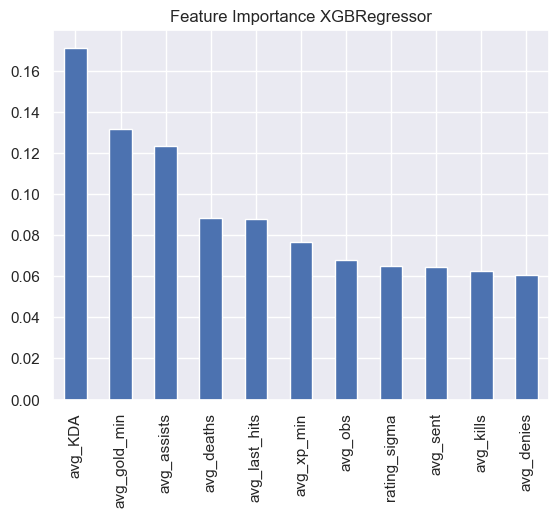

In [16]:
pd.Series(model.models_['XGBRegressor'][0].feature_importances_, index=model.ts.features_order_).sort_values(ascending=False).plot.bar(title='Feature Importance XGBRegressor')

In [17]:
pd.Series(model.models_['XGBRegressor'][0].feature_importances_, index=model.ts.features_order_)

avg_xp_min       0.076661
avg_gold_min     0.131842
avg_KDA          0.171304
avg_kills        0.062466
avg_assists      0.123177
avg_deaths       0.088509
avg_obs          0.067967
avg_sent         0.064579
rating_sigma     0.065035
avg_last_hits    0.087970
avg_denies       0.060489
dtype: float32

In [68]:
result_change_df = result_change_df.rename(columns={"Pipeline accuracy": "Random forest accuracy"})

In [69]:
result_change_df.set_index('horizon').head()

,Random forest accuracy,XGBRegressor accuracy
horizon,,
2,0.930678,0.907080
3,0.928097,0.883850
4,0.942847,0.828909
5,0.885693,0.865044


In [22]:
p.head()

,account_id,matches_amount,Pipeline,XGBRegressor,rating_mu
0,40,15,27.085515,28.184155,26.379654
1,40,16,27.037638,28.174322,25.244906
2,40,17,27.119267,28.080658,26.257341
3,40,18,26.995826,27.462259,27.211386
4,40,19,27.021264,27.948490,27.919298


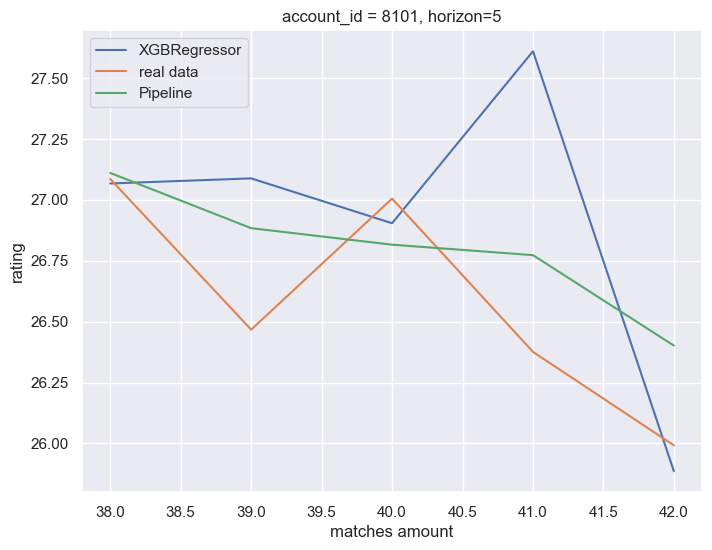

In [27]:
plt.figure(figsize=(8,6))

plt.plot(p[p["account_id"]==8101]["matches_amount"]
             , p[p["account_id"]==8101]["XGBRegressor"]
             , label="XGBRegressor")

plt.plot(p[p["account_id"]==8101]["matches_amount"]
             , p[p["account_id"]==8101]["rating_mu"]
             , label="real data")

plt.plot(p[p["account_id"]==8101]["matches_amount"]
             , p[p["account_id"]==8101]["Pipeline"]
             , label="Pipeline")
    
plt.xlabel('matches amount')
plt.ylabel('rating')

plt.title('account_id = 8101, horizon=5')
plt.legend()

In [43]:
unique_ids_train = train_df.account_id.unique()
for i in unique_ids_train:
    id_train_df = train_df[train_df["account_id"] == i]
    matches_amount = id_train_df.loc[id_train_df["matches_amount"].idxmax()]["matches_amount"]
    rating = id_train_df.loc[id_train_df["matches_amount"].idxmax()]["rating_mu"]
        
    new_row = {"account_id": i,
                "Pipeline": rating,
                "XGBRegressor": rating,
                "rating_mu": rating,
                "matches_amount": matches_amount}
    p.loc[len(p)] = new_row

In [56]:
import random


first_id = unique_ids[random.randint(0, len(unique_ids))]
second_id = unique_ids[random.randint(0, len(unique_ids))]
third_id = unique_ids[random.randint(0, len(unique_ids))]

In [62]:
third_id = unique_ids[random.randint(0, len(unique_ids))]

In [57]:
p = p.sort_values(['account_id', 'matches_amount'])

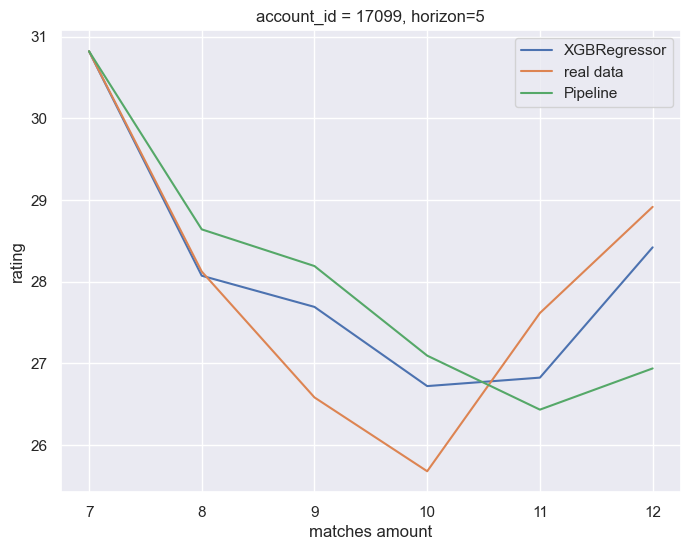

In [58]:
plt.figure(figsize=(8,6))

plt.plot(p[p["account_id"]==first_id]["matches_amount"]
             , p[p["account_id"]==first_id]["XGBRegressor"]
             , label="XGBRegressor")

plt.plot(p[p["account_id"]==first_id]["matches_amount"]
             , p[p["account_id"]==first_id]["rating_mu"]
             , label="real data")

plt.plot(p[p["account_id"]==first_id]["matches_amount"]
             , p[p["account_id"]==first_id]["Pipeline"]
             , label="Pipeline")
    
plt.xlabel('matches amount')
plt.ylabel('rating')

plt.title(f'account_id = {first_id}, horizon={horizon}')
plt.legend()

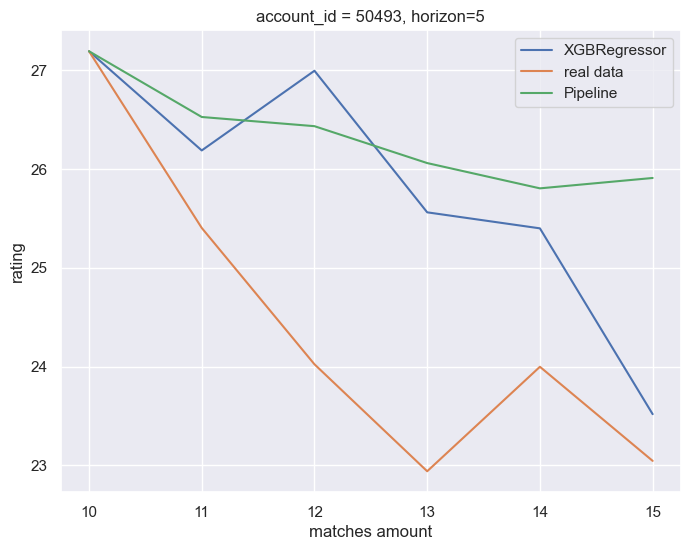

In [61]:
plt.figure(figsize=(8,6))

plt.plot(p[p["account_id"]==second_id]["matches_amount"]
             , p[p["account_id"]==second_id]["XGBRegressor"]
             , label="XGBRegressor")

plt.plot(p[p["account_id"]==second_id]["matches_amount"]
             , p[p["account_id"]==second_id]["rating_mu"]
             , label="real data")

plt.plot(p[p["account_id"]==second_id]["matches_amount"]
             , p[p["account_id"]==second_id]["Pipeline"]
             , label="Pipeline")
    
plt.xlabel('matches amount')
plt.ylabel('rating')

plt.title(f'account_id = {second_id}, horizon={horizon}')
plt.legend()

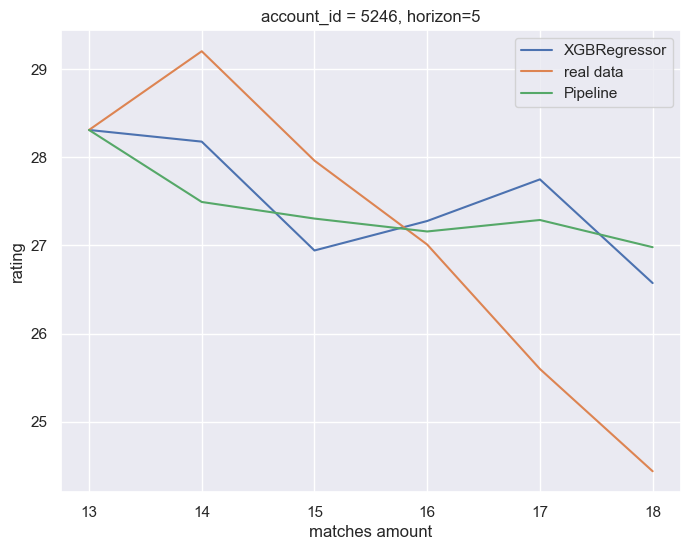

In [63]:
plt.figure(figsize=(8,6))

plt.plot(p[p["account_id"]==third_id]["matches_amount"]
             , p[p["account_id"]==third_id]["XGBRegressor"]
             , label="XGBRegressor")

plt.plot(p[p["account_id"]==third_id]["matches_amount"]
             , p[p["account_id"]==third_id]["rating_mu"]
             , label="real data")

plt.plot(p[p["account_id"]==third_id]["matches_amount"]
             , p[p["account_id"]==third_id]["Pipeline"]
             , label="Pipeline")
    
plt.xlabel('matches amount')
plt.ylabel('rating')

plt.title(f'account_id = {third_id}, horizon={horizon}')
plt.legend()